In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

%matplotlib inline

In [28]:
df = pd.read_csv("../data/reddit_data_raw_primary.csv")

df.head()

,id,author,flair,title,body,comments,permalink
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,NaN,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...


In [29]:
df.shape

(1018, 7)

In [30]:
df.describe()

,id,author,flair,title,body,comments,permalink
count,1018,1018,1018,1018,595,929,1018
unique,996,759,11,985,551,890,996
top,f9to6w,AutoModerator,Business/Finance,Daily Current Affairs,This is a weekly scheduled thread for all the ...,[deleted],/r/india/comments/f9to6w/daily_current_affairs/
freq,4,30,100,4,27,7,4


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1018 non-null   object
 1   author     1018 non-null   object
 2   flair      1018 non-null   object
 3   title      1018 non-null   object
 4   body       595 non-null    object
 5   comments   929 non-null    object
 6   permalink  1018 non-null   object
dtypes: object(7)
memory usage: 55.8+ KB


No need to change the data types of the Columns since Pandas stores strings as object

### Some EDA

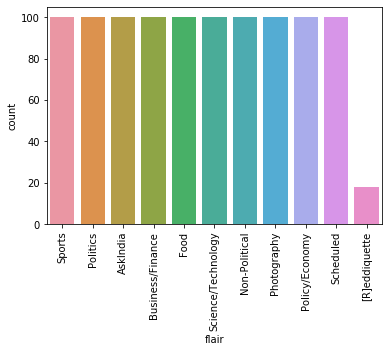

In [39]:
chart = sns.countplot(df["flair"])

chart.set_xticklabels(chart.get_xticklabels(),rotation = 90)

chart

In [40]:
df["body_and_comments"] = df["body"] + " " + df["comments"]

In [41]:
df.isna().sum()

id                     0
author                 0
flair                  0
title                  0
body                 423
comments              89
permalink              0
body_and_comments    467
dtype: int64

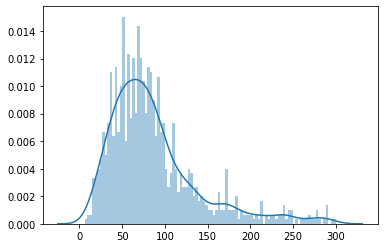

In [47]:
word_count = [len(text) for text in df["title"]]

sns.distplot(word_count, bins = 100)

In [55]:
df["permalink"][1:4]

1    /r/india/comments/fhvl03/delhi_deputy_chief_mi...
2    /r/india/comments/fl5tj6/what_is_a_sport_every...
3    /r/india/comments/exk8n6/govt_cuts_national_sp...
Name: permalink, dtype: object

In order to process the URLs we make us of the following function

In [57]:
def process_url(url):
    url = str(url)
    
    if('/r/india/comments/' in url):
        count = 0
        final_string = ''
        
        for i in range(len(url)):
            if url[i] == '/':
                count += 1
                
            elif count == 5:
                final_string += url[i]
        split_words = final_string.split('_')
        final_title = ' '.join(word for word in split_words)
        
        return str(final_title)
    else:
        print("Exception")
        return words

In [120]:
def plot_frequent_words(dataframes, flairs):
    count = 0
    fig = plt.figure()
    
    for d, dataframe in enumerate(dataframes):
        
        count += 1
        
        # Create the plot
        sns.barplot(
            x = 0,
            y = dataframe.index,
            data = dataframe,
            palette = "deep"
        )
        
        plt.title(f"Most common words under {flairs[d]}", size = 20)
        plt.xlabel("Frequency")
        plt.ylabel("Word", size = 30)
        plt.show()

In [64]:
for index, row in df.iterrows():
    row["processed_url"] = process_url(row["permalink"])
    
df.head()

,id,author,flair,title,body,comments,permalink,body_and_comments,processed_url
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,NaN,my schools 1980ish sports day score board
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,NaN,delhi deputy chief minister manish sisodia we
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...,One of the only team sports which can be playe...,what is a sport every indian born before 1990
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,NaN,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...,NaN,govt cuts national sports federations sai budget
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...,Just like camping/hiking has boomed this decad...,is snowboarding as a sport emerging trend in i...


In [ ]:
df["body-empty"] = df["body"].isnull()
df["comments-empty"] = df["comments"].isnull()

df.head()

In [112]:
combined_body_comments_array = []

for index, row in df.iterrows():
    body_comments_combined = ''
    if row["body-empty"] == False:
        body_comments_combined += str(row["body"])
        body_comments_combined += " "
    if row["comments-empty"] == False:
        body_comments_combined += str(row["comments"])
        body_comments_combined += " "
    
    combined_body_comments_array.append(body_comments_combined)
    
combined_body_comments_array[1]

'The players would still be at risk though.  '

In [113]:
df["body_comments_combined"] = combined_body_comments_array

df.head()

,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...,what is a sport every indian born before 1990,False,False,One of the only team sports which can be playe...
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,NaN,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...,govt cuts national sports federations sai budget,True,False,4D chess right there...
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...,is snowboarding as a sport emerging trend in i...,False,False,Just like camping/hiking has boomed this decad...


In [62]:
flairs = ["Sports", "Politics", "AskIndia", "Business/Finance", "Food", "Science/Technology", "Non-Political", "Photography", "Policy/Economy", "Scheduled", "[R]eddiquette"]

flairs

['Sports',
 'Politics',
 'AskIndia',
 'Business/Finance',
 'Food',
 'Science/Technology',
 'Non-Political',
 'Photography',
 'Policy/Economy',
 'Scheduled',
 '[R]eddiquette']

**VISUALISING FREQUENT WORDS IN `df['body_comments_combined']`**

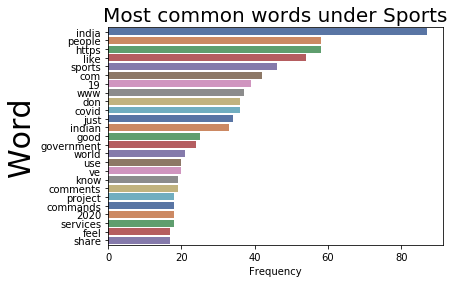

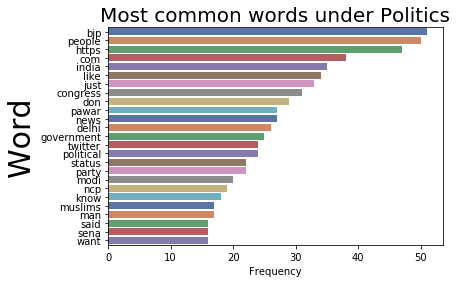

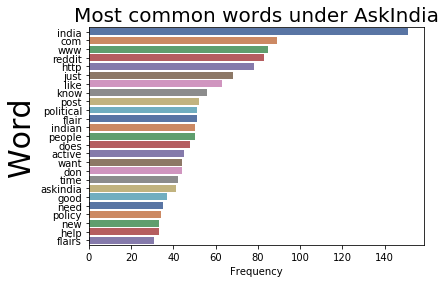

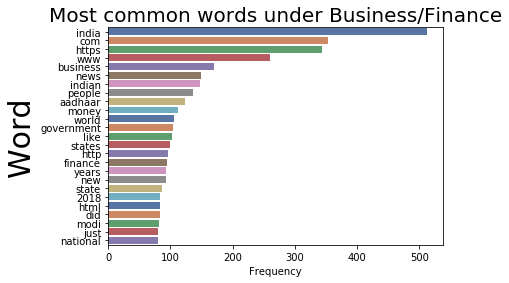

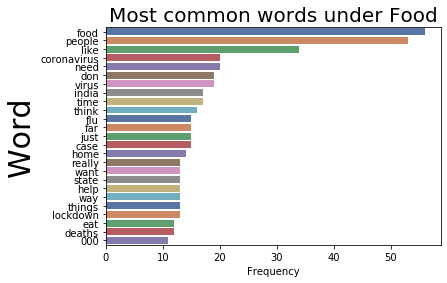

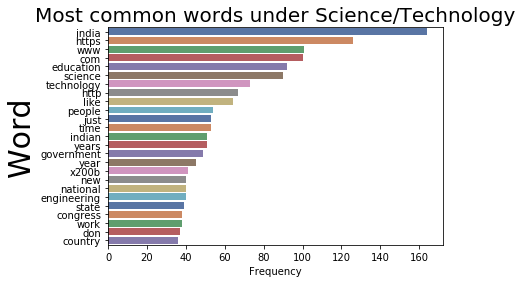

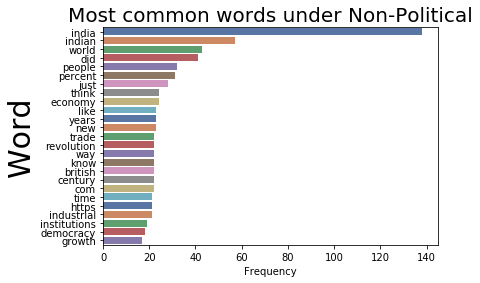

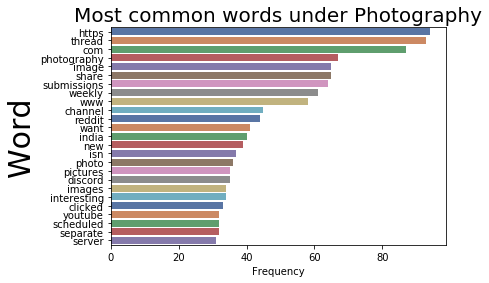

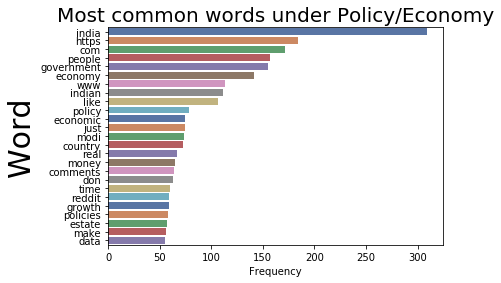

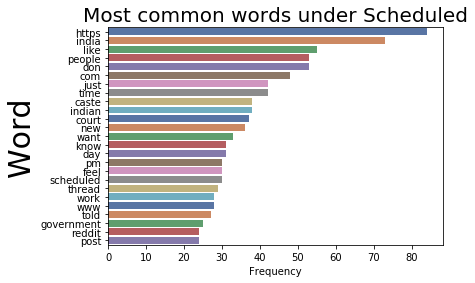

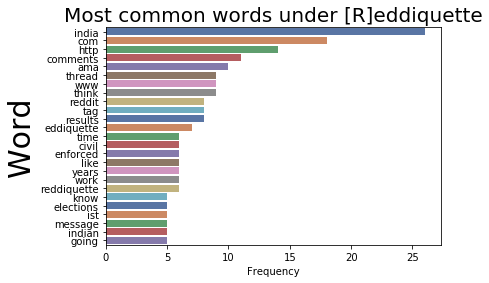

In [121]:
vectorized_flairs = []

# Initialising Count vectorizer
vectorizer = CountVectorizer()

for flair in flairs:
    cvec = CountVectorizer(stop_words="english")
    
    # Getting Part of Dataframe
    sub_df = df[df["flair"] == flair]
    
    # Fit-Transform
    vec = cvec.fit_transform(sub_df["body_comments_combined"])
    
    flair_vectorized = pd.DataFrame(vec.toarray(), columns=cvec.get_feature_names())
    
    vectorized_flair = pd.DataFrame(flair_vectorized.sum().sort_values(ascending = False).head(25))
    
    plot_frequent_words(dataframes=[vectorized_flair], flairs=[flair])

### We see that there are lot of words which occur in the flairs posts which are not useful when we run the model

Hence we **CREATE A CUSTOMISED LIST OF STOP WORDS** and then add it to the existing list of stop words  

In [126]:
# Using Existing stopwords
nltk.download("stopwords")

# Adding new stopwords to the Set
new_stopwords = ["https", "http", "like", "19", "com", "www", "use", "ve",
                 "just", "does", "don", "t", "did"]

stopwords = stopwords.words('english')

stopwords.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
# Creating objects of lemmatizer and tokenizer

nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# Setup lemmatizer
lemmatized_posts = []

for post in df["body_comments_combined"]:
    tokens = tokenizer.tokenize(post)
    post = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(" ".join(post))

# Adding the lemmatized posts to df
df["lemmatized_body_comments"] = lemmatized_posts

df.head()

[nltk_data] Downloading package wordnet to /home/aditya/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined,lemmatized_body_comments
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...,Well when i wa studying there i heard it from ...
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.,The player would still be at risk though
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...,what is a sport every indian born before 1990,False,False,One of the only team sports which can be playe...,One of the only team sport which can be played...
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,NaN,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...,govt cuts national sports federations sai budget,True,False,4D chess right there...,4D chess right there
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...,is snowboarding as a sport emerging trend in i...,False,False,Just like camping/hiking has boomed this decad...,Just like camping hiking ha boomed this decade...


In [136]:
df["lemmatized_body_comments"] = df["lemmatized_body_comments"].str.replace("http\S+","")

In [137]:
# VISUALISING THE BASELINE

round(df["flair"].value_counts(normalize=True)*100,2)

Business/Finance      9.82
Sports                9.82
Food                  9.82
Scheduled             9.82
Policy/Economy        9.82
Non-Political         9.82
Science/Technology    9.82
Photography           9.82
Politics              9.82
AskIndia              9.82
[R]eddiquette         1.77
Name: flair, dtype: float64

We observe that percent of posts of the flair **[R]eddiquette** is very low, but the other flairs are perfectly balanced

We'll now do the same pre processing and cleaning for 
- `df['body']`
- `df['title']`
- `df['permalink']`
- `df['comments']`
- All of the above

**VISUALISING FREQUENT WORDS IN `df['title']`**

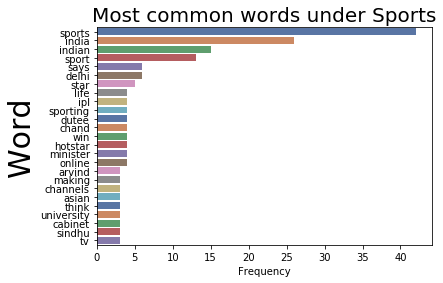

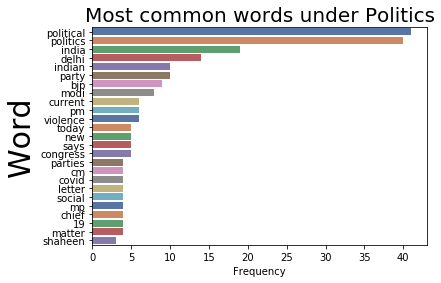

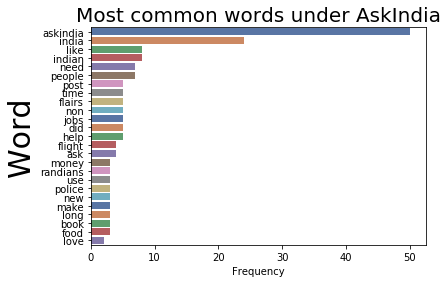

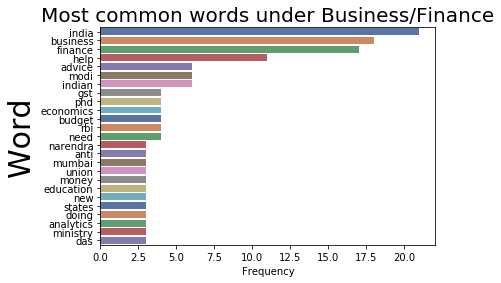

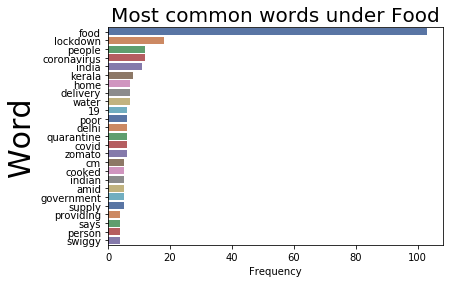

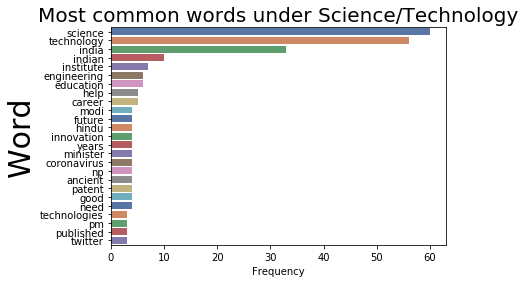

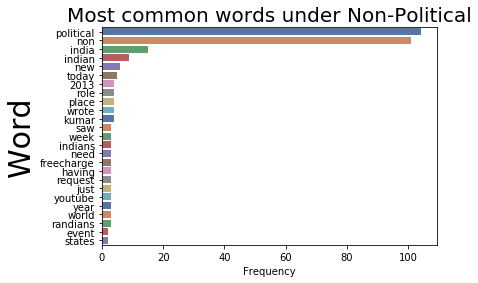

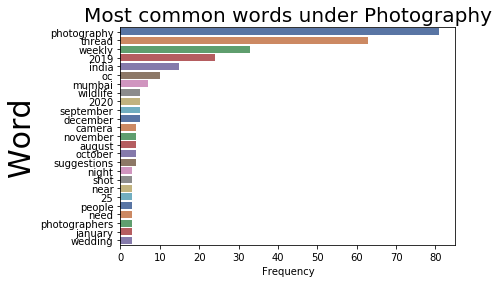

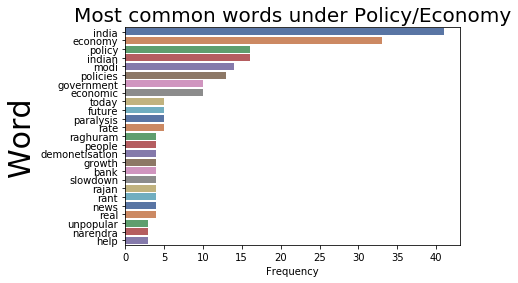

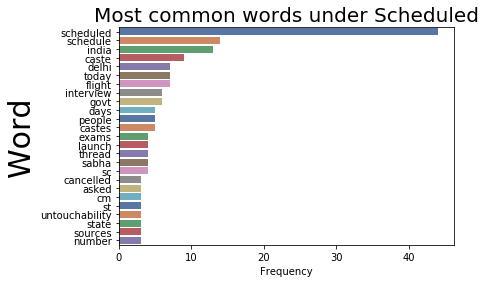

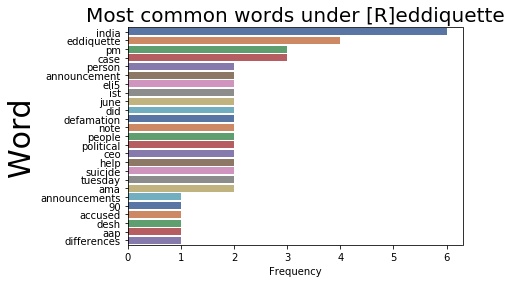

In [138]:
vectorized_flairs = []

# Initialising Count vectorizer
vectorizer = CountVectorizer()

for flair in flairs:
    cvec = CountVectorizer(stop_words="english")
    
    # Getting Part of Dataframe
    sub_df = df[df["flair"] == flair]
    
    # Fit-Transform
    vec = cvec.fit_transform(sub_df["title"])
    
    flair_vectorized = pd.DataFrame(vec.toarray(), columns=cvec.get_feature_names())
    
    vectorized_flair = pd.DataFrame(flair_vectorized.sum().sort_values(ascending = False).head(25))
    
    plot_frequent_words(dataframes=[vectorized_flair], flairs=[flair])

We can remove the word India from each of them since it is relatively high in most of the flair posts

But we'll tackle that later

In [140]:
# Using Existing stopwords
nltk.download("stopwords")

# Adding new stopwords to the Set
newer_stopwords = ["says", "help", "wrote"]

stopwords.extend(newer_stopwords)

[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
# Creating objects of lemmatizer and tokenizer

nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# Setup lemmatizer
lemmatized_posts = []

for post in df["title"]:
    tokens = tokenizer.tokenize(post)
    post = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(" ".join(post))

# Adding the lemmatized posts to df
df["lemmatized_title"] = lemmatized_posts

df.head()

[nltk_data] Downloading package wordnet to /home/aditya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined,lemmatized_body_comments,lemmatized_title
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score board
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...,what is a sport every indian born before 1990,False,False,One of the only team sports which can be playe...,One of the only team sport which can be played...,What is a sport every Indian born before 1990 ...
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,NaN,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...,govt cuts national sports federations sai budget,True,False,4D chess right there...,4D chess right there,Govt cut National Sports Federations SAI budge...
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...,is snowboarding as a sport emerging trend in i...,False,False,Just like camping/hiking has boomed this decad...,Just like camping hiking ha boomed this decade...,Is snowboarding a a sport emerging trend in India


In [142]:
# NOT REQUIRED, BUT REPEATING NEVERTHELESS
df["lemmatized_title"] = df["lemmatized_title"].str.replace("http\S+","")

**VISUALISING FREQUENT WORDS IN `df['body'] and df['comments']`**

In [145]:
# FIT_TRANSFORM WON'T WORK IS nan is PRESENT
df1 = df.replace(np.nan, '', regex=True)

df1.head()

,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined,lemmatized_body_comments,lemmatized_title
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score board
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...,what is a sport every indian born before 1990,False,False,One of the only team sports which can be playe...,One of the only team sport which can be played...,What is a sport every Indian born before 1990 ...
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...,govt cuts national sports federations sai budget,True,False,4D chess right there...,4D chess right there,Govt cut National Sports Federations SAI budge...
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...,is snowboarding as a sport emerging trend in i...,False,False,Just like camping/hiking has boomed this decad...,Just like camping hiking ha boomed this decade...,Is snowboarding a a sport emerging trend in India


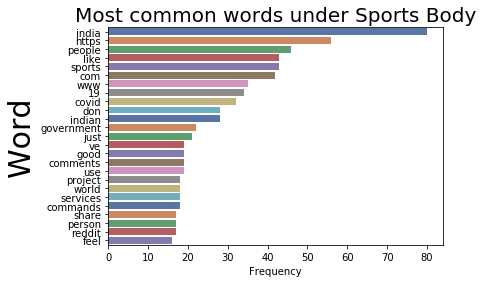

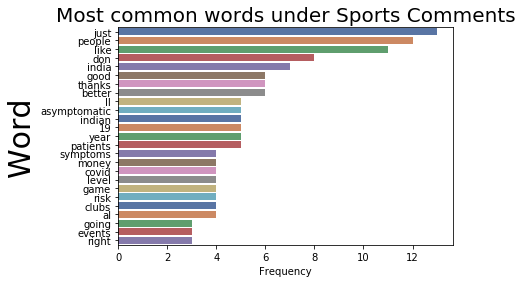

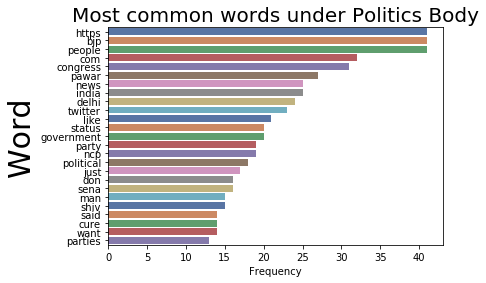

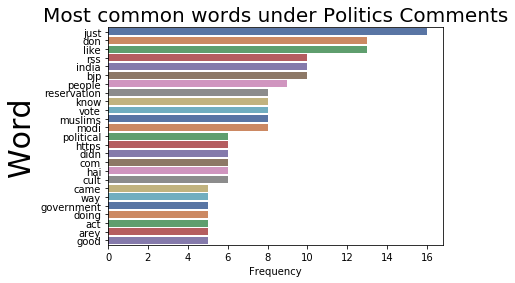

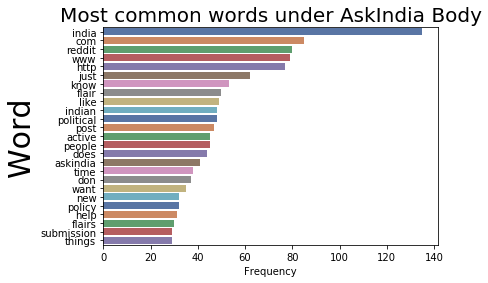

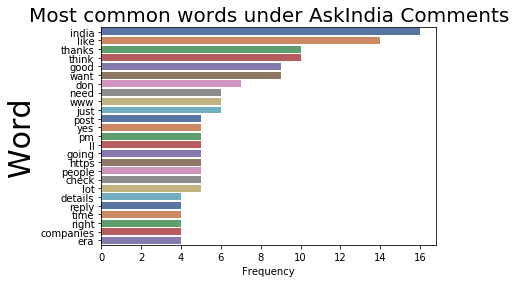

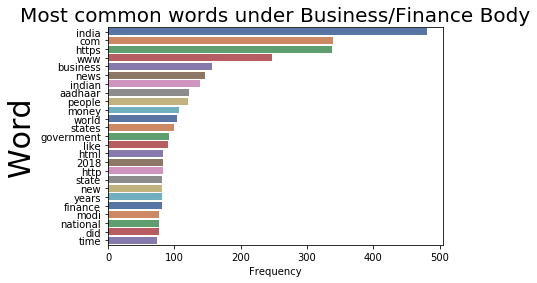

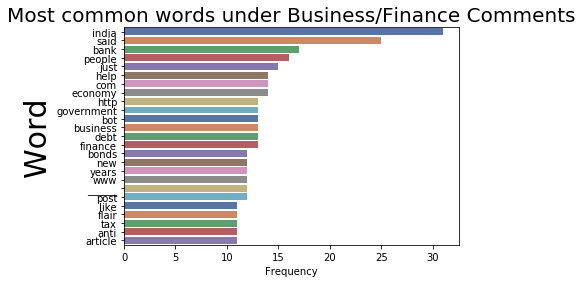

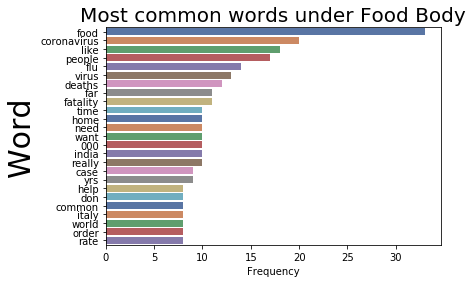

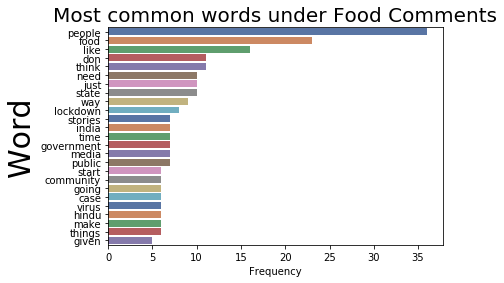

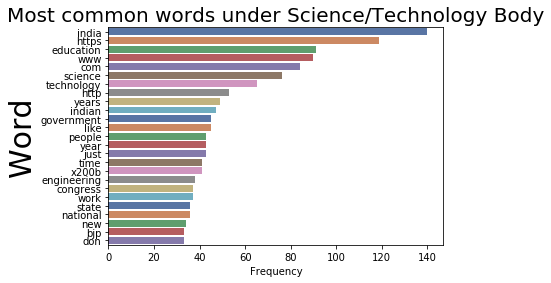

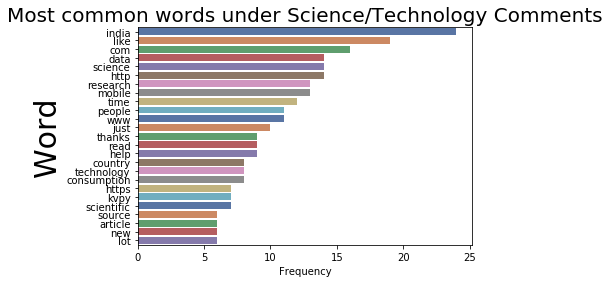

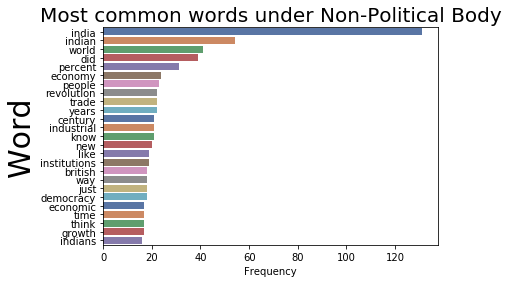

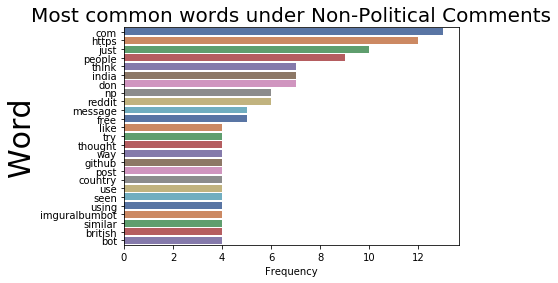

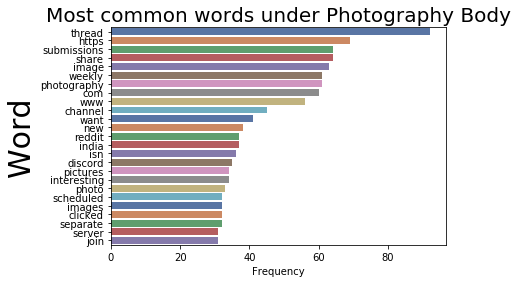

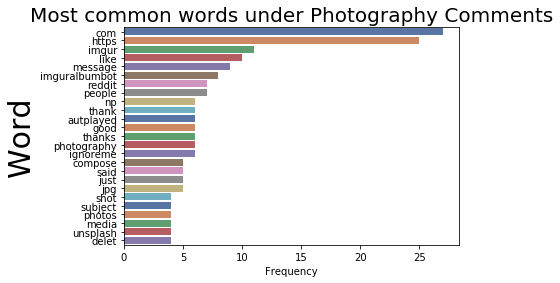

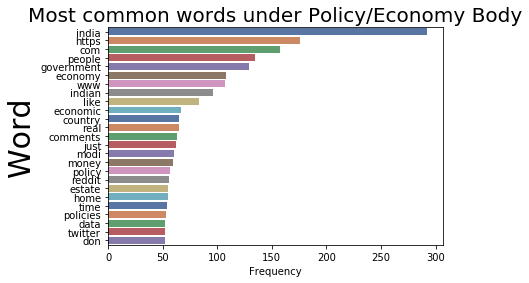

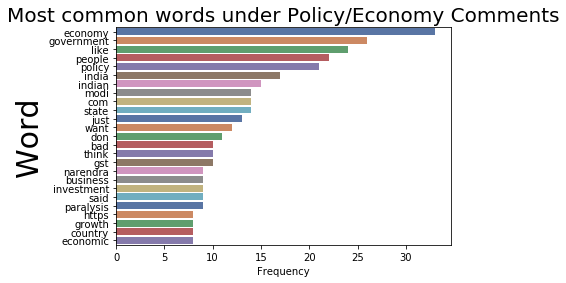

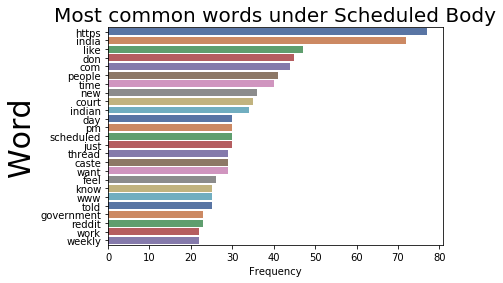

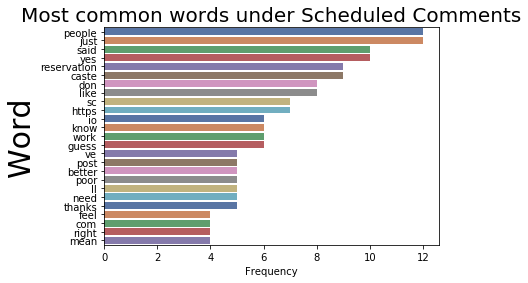

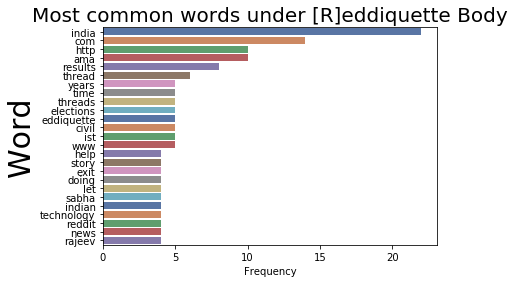

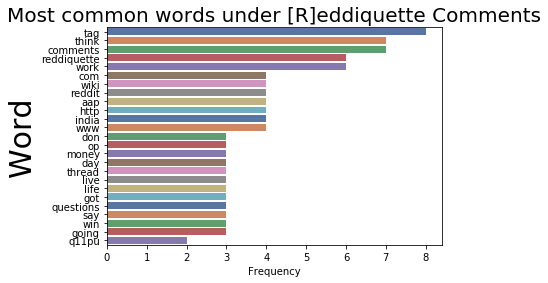

In [146]:
vectorized_flairs = []

# Initialising Count vectorizer
vectorizer = CountVectorizer()

for flair in flairs:
    cvec_body = CountVectorizer(stop_words="english")
    cvec_comments = CountVectorizer(stop_words="english")

    # Getting Part of Dataframe
    sub_df = df1[df1["flair"] == flair]
    
    # Fit-Transform
    vec_body = cvec_body.fit_transform(sub_df["body"])
    vec_comments = cvec_comments.fit_transform(sub_df["comments"])
    
    flair_vectorized_body = pd.DataFrame(vec_body.toarray(), columns=cvec_body.get_feature_names())
    flair_vectorized_comments = pd.DataFrame(vec_comments.toarray(), columns=cvec_comments.get_feature_names())
    
    vectorized_flair_body = pd.DataFrame(flair_vectorized_body.sum().sort_values(ascending = False).head(25))
    vectorized_flair_comments = pd.DataFrame(flair_vectorized_comments.sum().sort_values(ascending = False).head(25))
    
    plot_frequent_words(dataframes=[vectorized_flair_body, vectorized_flair_comments], flairs=[str(flair + " Body"),str(flair + " Comments")])

In [147]:
# Using Existing stopwords
nltk.download("stopwords")

# Adding new stopwords to the Set
newest_stopwords = ["says", "help", "wrote", "https", "http", "like", "19", "com", "www", "use", "ve",
                 "just", "does", "don", "t", "did"]

stopwords.extend(newest_stopwords)

[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

lemmatized_posts_body = []
lemmatized_posts_comments = []

for post in df1["body"]:
    tokens = tokenizer.tokenize(post)
    post   = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts_body.append(" ".join(post))

for post in df1["comments"]:
    tokens = tokenizer.tokenize(post)
    post   = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts_comments.append(" ".join(post))
    
df["lemmatized_body_only"] = lemmatized_posts_body
df["lemmatized_comments_only"] = lemmatized_posts_comments

df.head()

,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined,lemmatized_body_comments,lemmatized_title,lemmatized_body_only,lemmatized_comments_only
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score board,,Well when i wa studying there i heard it from ...
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...,,The player would still be at risk though
2,fl5tj6,d2a2d2a,Sports,What is a sport every Indian born before 1990 ...,One of the only team sports which can be playe...,We played this as kids too! But I don’t think ...,/r/india/comments/fl5tj6/what_is_a_sport_every...,what is a sport every indian born before 1990,False,False,One of the only team sports which can be playe...,One of the only team sport which can be played...,What is a sport every Indian born before 1990 ...,One of the only team sport which can be played...,We played this a kid too But I don t think I e...
3,exk8n6,hipporama,Sports,Govt cuts National Sports Federations & SAI bu...,NaN,4D chess right there...,/r/india/comments/exk8n6/govt_cuts_national_sp...,govt cuts national sports federations sai budget,True,False,4D chess right there...,4D chess right there,Govt cut National Sports Federations SAI budge...,,4D chess right there
4,fhb1v6,wildergears,Sports,Is snowboarding as a sport emerging trend in I...,Just like camping/hiking has boomed this decad...,But recent events like khelo india 2020 - Wint...,/r/india/comments/fhb1v6/is_snowboarding_as_a_...,is snowboarding as a sport emerging trend in i...,False,False,Just like camping/hiking has boomed this decad...,Just like camping hiking ha boomed this decade...,Is snowboarding a a sport emerging trend in India,Just like camping hiking ha boomed this decade...,But recent event like khelo india 2020 Winter ...


In [149]:
df1 = df.replace(np.nan, "", regex=True)

In [151]:
df1["all_combined"] = df1["lemmatized_title"] + df1["lemmatized_body_comments"]+df1["processed_url"]

df1.head(2)

,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined,lemmatized_body_comments,lemmatized_title,lemmatized_body_only,lemmatized_comments_only,all_combined
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score board,,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score boardWell ...
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...,,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...


In [152]:
# Using Existing stopwords
nltk.download("stopwords")

# Adding new stopwords to the Set
full_stopwords = ["says", "help", "wrote", "https", "http", "like", "19", "com", "www", "use", "ve",
                 "just", "does", "don", "t", "did"]

stopwords.extend(full_stopwords)

[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

lemmatized_combined = []

for post in df1["all_combined"]:
    tokens = tokenizer.tokenize(post)
    post   = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_combined.append(" ".join(post))
    
df["lemmatized_all_params"] = lemmatized_combined

df.head(2)

,id,author,flair,title,body,comments,permalink,processed_url,body-empty,comments-empty,body_comments_combined,lemmatized_body_comments,lemmatized_title,lemmatized_body_only,lemmatized_comments_only,lemmatized_all_params
0,fqgrjr,legithousefly,Sports,My school’s 1980ish sports day score board,NaN,Well when i was studying there i heard it from...,/r/india/comments/fqgrjr/my_schools_1980ish_sp...,my schools 1980ish sports day score board,True,False,Well when i was studying there i heard it from...,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score board,,Well when i wa studying there i heard it from ...,My school s 1980ish sport day score boardWell ...
1,fhvl03,hipporama,Sports,Delhi Deputy Chief Minister Manish Sisodia: We...,NaN,The players would still be at risk though.,/r/india/comments/fhvl03/delhi_deputy_chief_mi...,delhi deputy chief minister manish sisodia we,True,False,The players would still be at risk though.,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...,,The player would still be at risk though,Delhi Deputy Chief Minister Manish Sisodia We ...


In [160]:
# EXPORTING PRE-PROCESSED and CLEANED DATA 

df.to_csv("../data/reddit_data_preprocessed.csv", index=False)